In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перевод текстов

Данный материал подготовлен на основании [инструкций](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) от PyTorch.

В рамках данных материалов решается задача создания модели для машинного перевода с одного языка на другой с использовнием рекурентных нейронных сетей с LSTM- и GRU-ячейками.

Общая архитектура модели, обеспечивающей возможность перевода, включает в себя две сети: декодер и энкодер.

Архитектура сети позволяет обеспечить преобразование входного текста в определённую числовую последовательность, которая затем преобразуется в текст на новом языке.

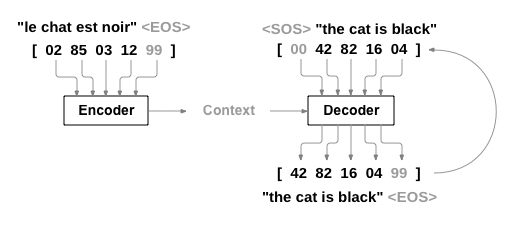

## Подготовка данных

В качестве конкретной задчи будет решаться задача машинного перевода с русского на английский языки. Обратите внимание, что нейронная сеть учиться переводу "в одну сторону". Если хотим обратный перевод, нужно обучить другую модель.

In [ ]:
device

device(type='cuda')

Использование команды с ! в начале позволяет обратиться к ядру равзвёрнутого ноутбка. В данном случае из интеренета будет скачен необходимый набор данных, который будет затем разархивирован и просмтрен.

In [ ]:
!wget https://www.manythings.org/anki/rus-eng.zip

--2024-01-07 11:08:45--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16065699 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.32M  48.2MB/s    in 0.3s    

2024-01-07 11:08:46 (48.2 MB/s) - ‘rus-eng.zip’ saved [16065699/16065699]



In [ ]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
!tail rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

Для использования инструментов машинного обучения необходимо определиться, каким именно образом будет происходить преобразование поступающих объектов в числа. В данном случае каждое слово будет замещаться на определнный числовой индекс.

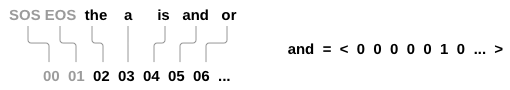

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Для того, чтобы обеспечить более эффективную работу модели необходимо преобразовать слова из unicode в asii. В процессе также будут обрезаны знаки припинания, и все слова приведены к одному регистру, так как это не значимые для перевода элементы письма.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?а-яА-Я]+", r" ", s)
    return s

В процессе обучения мы разделим файл на строки, а строки, соответственно на пары фраз на русском и английском языке.

In [ ]:
lines = open('rus.txt', encoding='utf-8').read().strip().split('\n')

In [ ]:
lines[0]

'Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)'

In [ ]:
for l in lines:
    s = l.split('\t')[0:2]
    for st in s:
        print(normalizeString(st))
    #print([normalizeString(st) for st in s])
    break

go .
марш !


In [ ]:
pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]

In [ ]:
pairs[0]

['go .', 'марш !']

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')

    lines = open('rus.txt', encoding='utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Для упрощения обучения, приложения, которые длиннее, чем 10 слов, будут проигнорированы, также будут обработаны английские префиксы, в которых могли быть использованы апострофы.

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 487600 sentence pairs
Trimmed to 28240 sentence pairs
Counting words...
Counted words:
rus 10119
eng 4289
['у тебя будет сестричка .', 'you re going to have a little sister .']


## Сети с памятью

Ключевая проблема рекурентных сетей состоит в том, что они должны обрабатывать большой по числу событий поток входной информации. Иногда, при этом, реашающими являются "ближайшие" друг к другу события. А иногда определюящая информацию может содержать наиболее далёкий элемент последовательности.

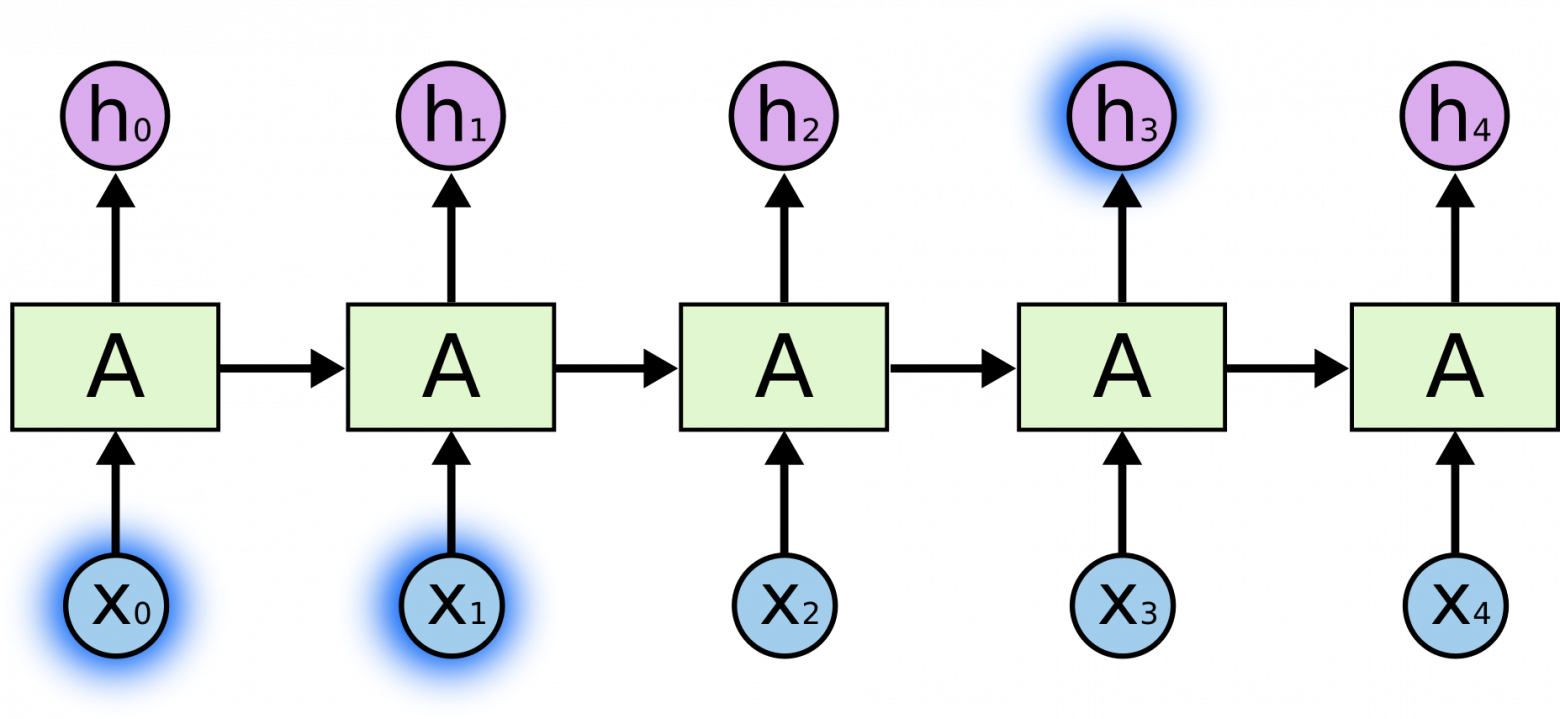

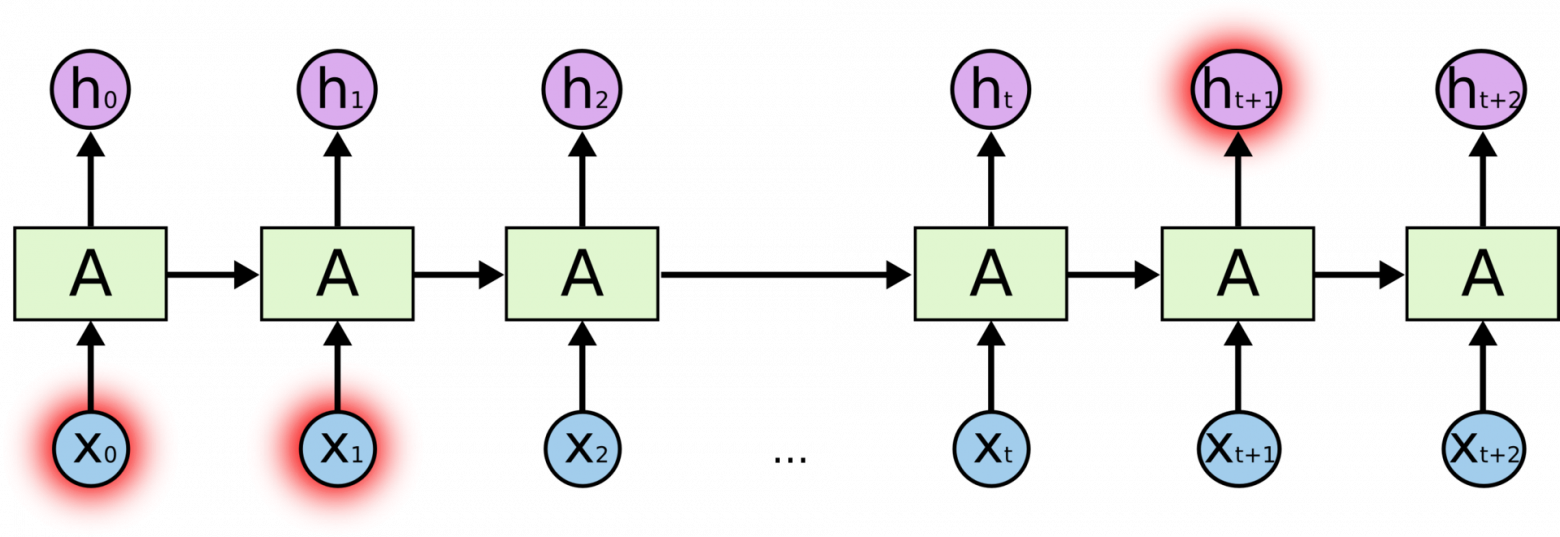

### LSTM

Впервые модель, которая позволяет избежать (или учесть) описанные выше проблемы была предложена в 1997 году (Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory." Neural computation 9, no. 8 (1997): 1735-1780.). Авторы называли её "долгая краткосрочная память". К активному внедрению этой памяти (в виде ячеек) вернулись после 2012 года.

Ячейка LSTM представляет собой набор различных слоёв и операций работы с ними, которые в итоге выдают на выходе три состояния - короткую память, долгую память

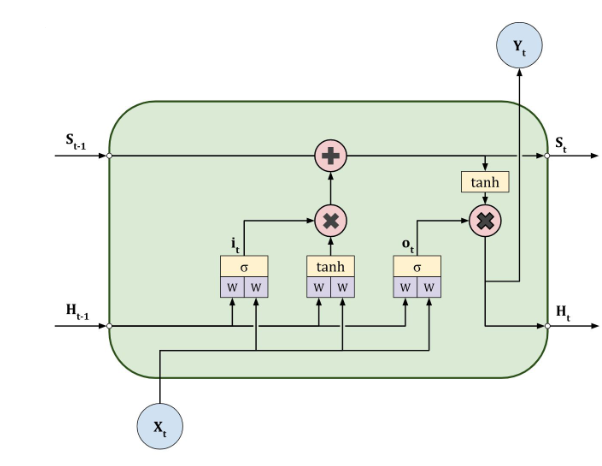

То есть, общая схема рекурентной сети будет выглядеть следующим образом:
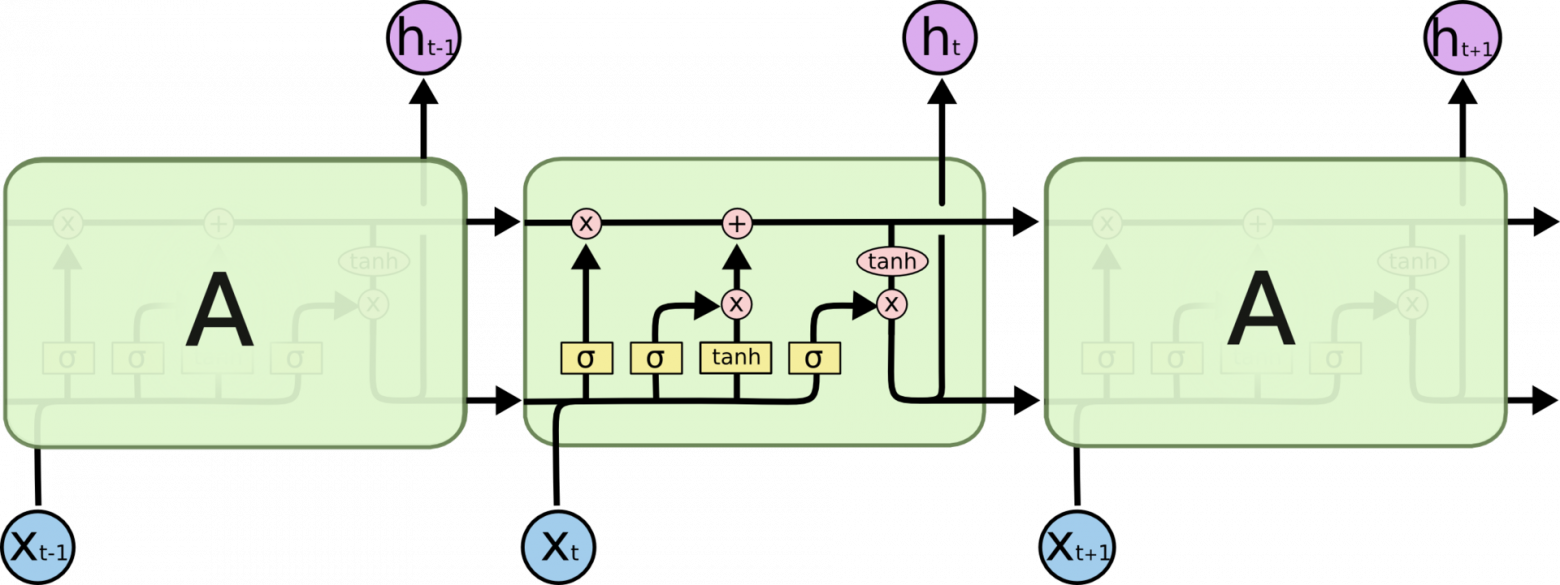

#### Как работает LSTM?

Основной компонент LSTM - ячейка долгосрочной памяти. LSTM может удалять информацию из состояния ячейки; этот процесс регулируется структурами, называемыми фильтрами (gates). Фильмы отмечены на это картинке светло-красными кружочками с соответствующими занками.

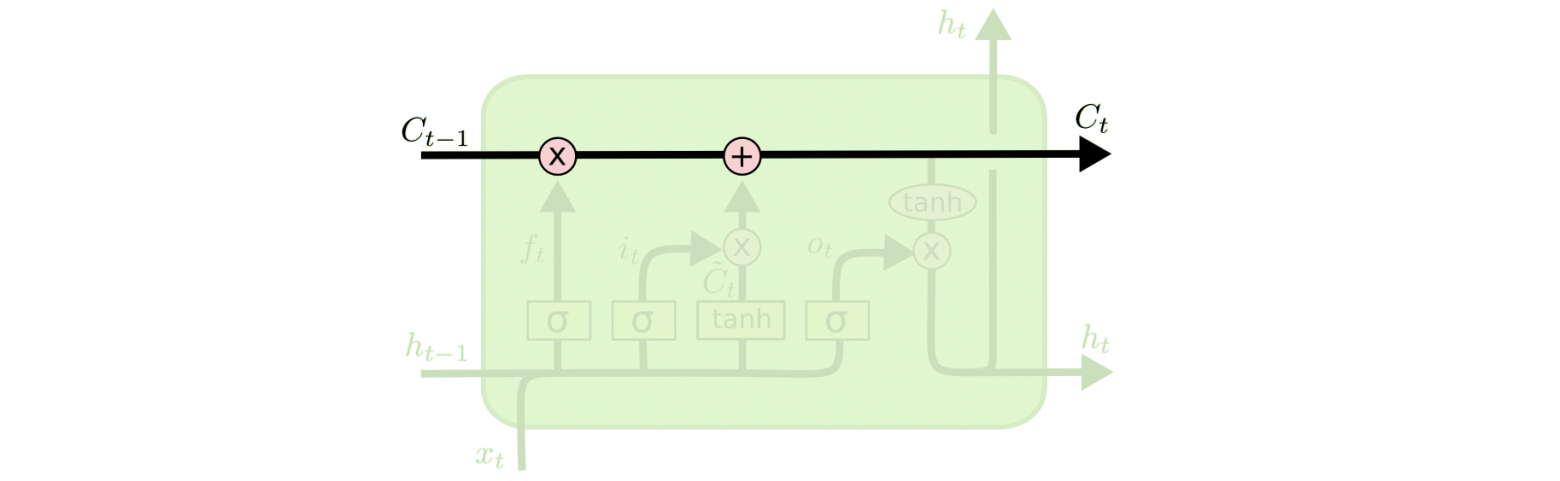

Шаг №1.

Самый первый фильтр определяет то, какая информация будет "забыта" ячейкой.

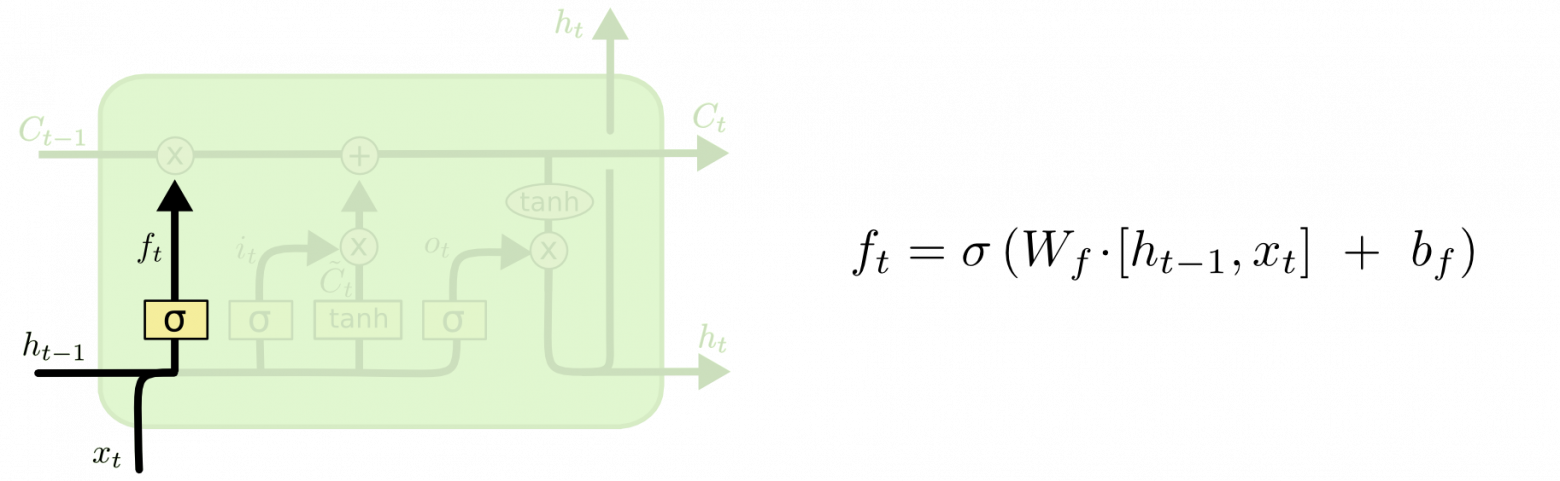

Шаг №2.

Второй фильтр определяет то, какая, во-первых информация должна быть обновлена, а, во-вторых, на какие значение должно произойти обновление.

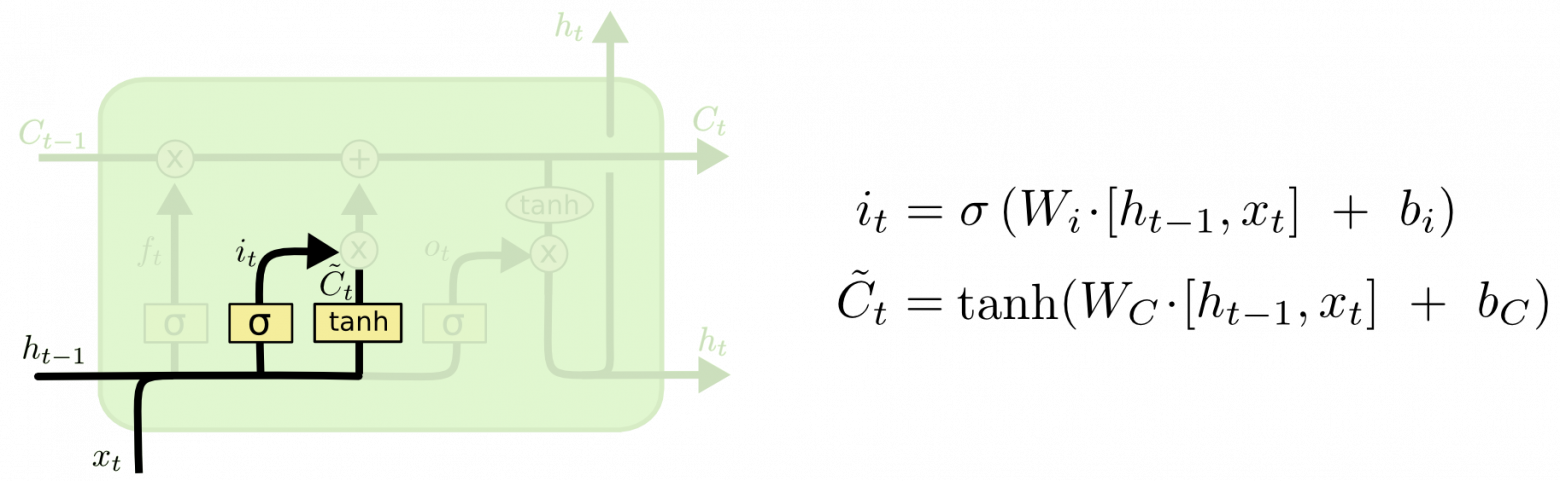

Шаг №3.

Обновление состояния памяти. Полученные на предыдущем шаге результаты сохраняются в долговременной памяти. Эти значения далее не обновляются.

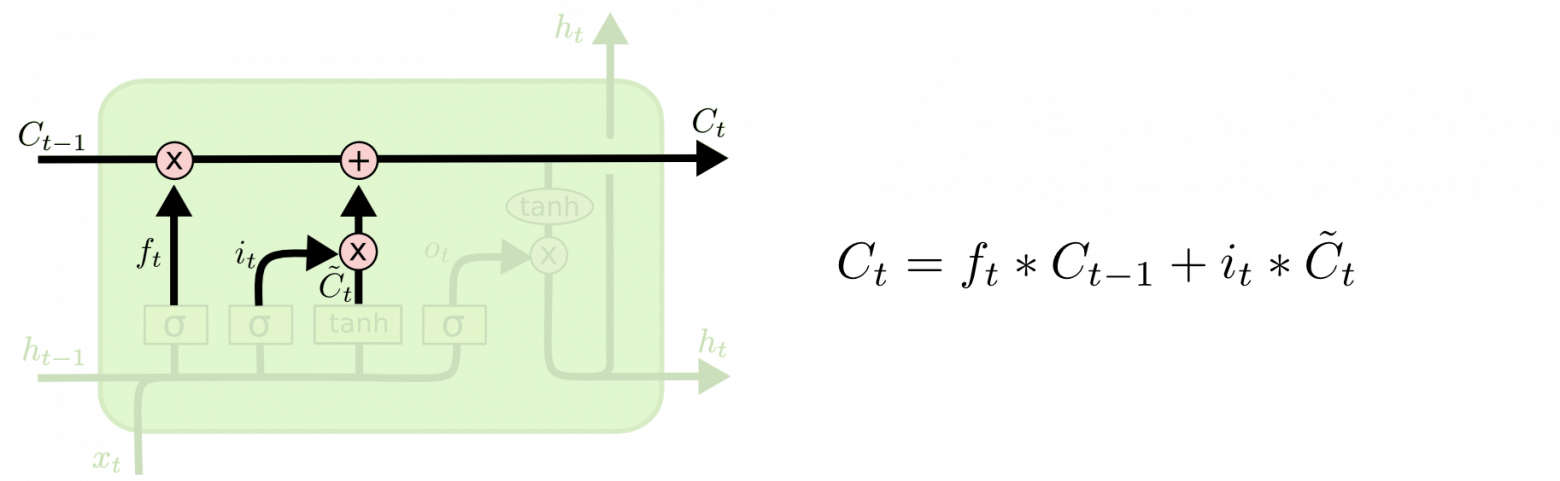

Шаг №4.

Получаем выходные состояния. Обратие внимание, что полученная информация уходит как  на выход из ячейке в качестве результата, так и в "короткую" память, котороя получается из "длинной".

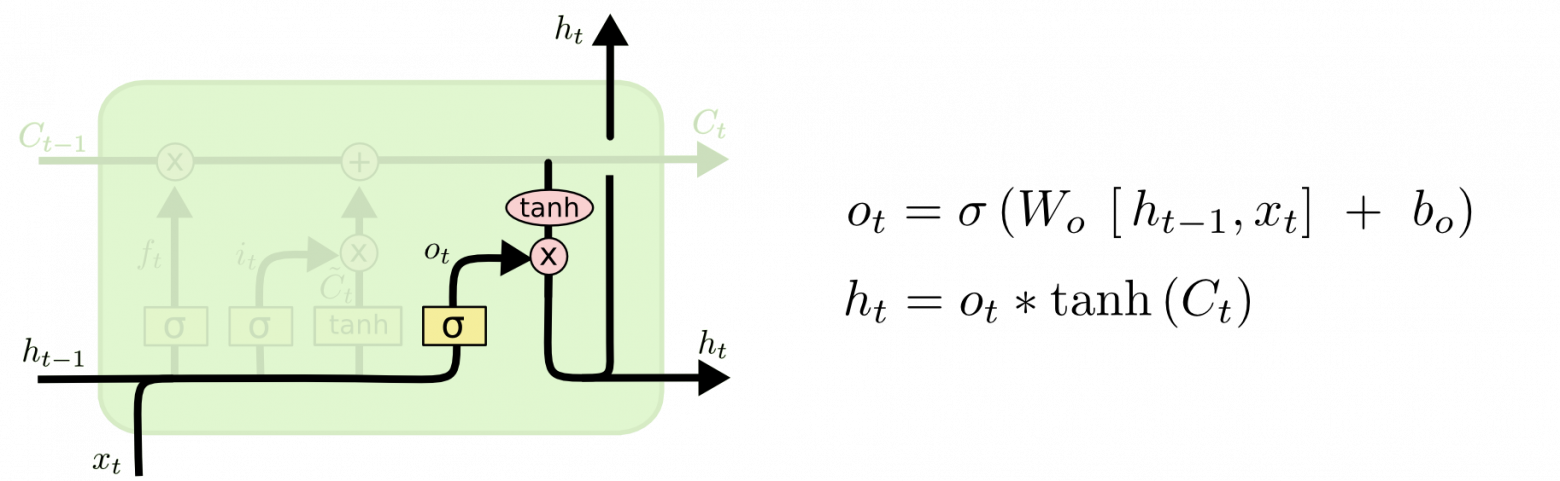

## GRU

В 2012 году (спустя 15 ! лет) была предложена наиболее популярная на сегодня вариация рекуррентной ячейки - управляваемая рекурентная ячейка (Gated RU).

Cho, Kyunghyun, Bart Van Merriënboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, and Yoshua Bengio. "Learning phrase representations using RNN encoder-decoder for statistical machine translation." arXiv preprint arXiv:1406.1078 (2014).


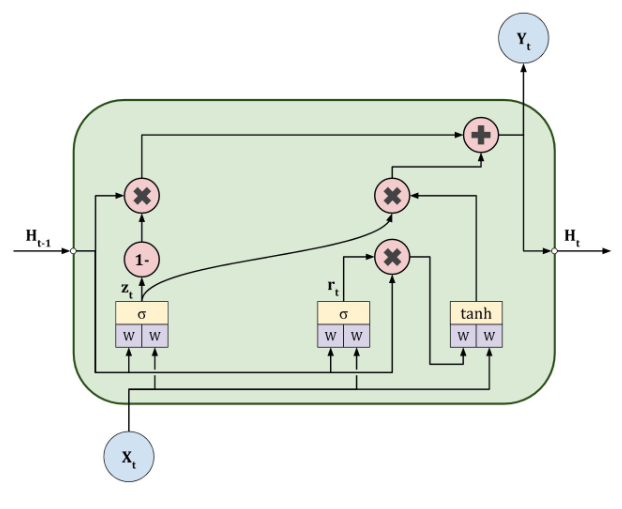


*   GRU быстрее обучается в силу меньше числа параметров
*   GRU работает лучше LSTM на малом объёме данных
*   GRU проще
*   LSTM в теории должен лучше запоминать долгие последовательности и выигрывать у GRU на таких задачах








## Подготовка нейросетевых элементов

Наша нейронная сеть будет состоять из экодера и декодера. По существу - они очень просто устроены.

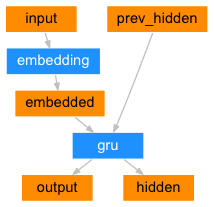

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_l = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers = num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_l, 1, self.hidden_size, device=device)

Декодер в целом устроен не менее просто.

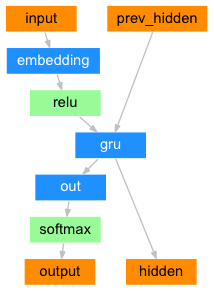

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers = 1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers = num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Подготовка к обучению

Для проведения процедуры обучения необходимо преобразовать данные таким образом, чтобы они были понятны Torch, то есть создать тензоры.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

В рамках процедуры обучения используется дополнительное ускорение сходимости, которое называется "форсированное обучение". Этот параметр определяет то, с какой вероятностью для обучения будут браться реальные или гипотетические данные для обучения. То есть, предсказания сети или известные нам заранее правильные ответы.

В целом процедура станадартная.

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 6s (- 15m 31s) (5000 6%) 3.1336
2m 3s (- 13m 23s) (10000 13%) 2.5986
3m 1s (- 12m 4s) (15000 20%) 2.3758
3m 58s (- 10m 54s) (20000 26%) 2.1300
4m 56s (- 9m 52s) (25000 33%) 1.9993
5m 54s (- 8m 51s) (30000 40%) 1.8716
6m 51s (- 7m 50s) (35000 46%) 1.7702
7m 49s (- 6m 50s) (40000 53%) 1.6394
8m 47s (- 5m 51s) (45000 60%) 1.5677
9m 45s (- 4m 52s) (50000 66%) 1.4906
10m 43s (- 3m 53s) (55000 73%) 1.4279
11m 41s (- 2m 55s) (60000 80%) 1.3749
12m 39s (- 1m 56s) (65000 86%) 1.3123
13m 36s (- 0m 58s) (70000 93%) 1.2320
14m 35s (- 0m 0s) (75000 100%) 1.1968


In [ ]:
evaluateRandomly(encoder1, decoder1)

> вы такои трус .
= you re such a coward .
< you re such a coward . <EOS>

> он невероятно глуп .
= he s incredibly stupid .
< he is stupid at the <EOS>

> мы тебе не враги .
= we re not your enemies .
< we re not going back . <EOS>

> я совсем не романтик .
= i m not romantic at all .
< i m not at all a . <EOS>

> мы шутим .
= we re joking .
< we re shy . <EOS>

> я ему глубоко обязан .
= i am deeply in debt to him .
< i m getting in the . . <EOS>

> ты невероятен .
= you re unbelievable .
< you re unfriendly . <EOS>

> вечно ты жалуешься на мужа .
= you are always complaining about your husband .
< you are always complaining about your husband . <EOS>

> я уверена .
= i m positive .
< i m sure . <EOS>

> я их не критикую .
= i m not criticizing them .
< i m not going to <EOS>

